<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Tasks
<hr/>



1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

# Import Necessary Libraries

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import cv2
import os
from torchvision import transforms
from torch.nn import functional as F
from skimage import io
from sklearn.model_selection import train_test_split
import keras
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import gc

# Load Dataset and Prepare It

Because of the size of the dataset we can not use the previously used techniques to load it into colab, so we need to get a little creative!
We first create a dataframe of the dataset and design a class to elicit specific parts of this dataframe and convert it into a regular set. The definition of the dataframe and the class are as follow:

In [13]:
class ImageDataset(Dataset):
    """
    Custom dataset class for handling image data for low-resolution and high-resolution images.
    Args:
        data (DataFrame): A pandas DataFrame containing paths to the low-res and high-res images.
        transform (callable, optional): Optional transformation to be applied on images.
        shuffle (bool, optional): Whether to shuffle the dataset upon initialization.
    """
    def __init__(self, data, transform=None, shuffle=False):
        self.data = data  # Store the DataFrame containing image paths
        self.transform = transform  # Store the image transformations to apply
        self.shuffle = shuffle  # Store shuffle option

        # Shuffle the dataset if required
        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        """
        Shuffle the dataset in-place. This can be useful to randomize the data order during training.
        """
        self.data = self.data.sample(frac=1).reset_index(drop=True)  # Randomly shuffle rows

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Retrieve a sample pair (low-res and high-res images) from the dataset at a given index.
        Args:
            index (int): Index of the image pair to retrieve.
        Returns:
            Tuple[Tensor, Tensor]: A tuple of transformed low-res and high-res images.
        """
        # Get file paths for low-res and high-res images
        low_res_image_path = self.data['low_res'].iloc[index]
        hi_res_image_path = self.data['high_res'].iloc[index]

        # Load the images from the file system
        low_res_image = Image.open(low_res_image_path)
        hi_res_image = Image.open(hi_res_image_path)

        # Apply transformations if provided
        if self.transform:
            low_res_image = self.transform(low_res_image)
            hi_res_image = self.transform(hi_res_image)

        return low_res_image, hi_res_image  # Return image pair as tensors


# Define the base path to the dataset folder
path = '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/'

# Define paths to high-res and low-res image folders
hires_folder = os.path.join(path, 'high res')
lowres_folder = os.path.join(path, 'low res')

# Load image data information from a CSV file
data = pd.read_csv(path+"image_data.csv")

# Update file paths in the DataFrame to include full paths
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder, x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder, x))

# Define transformations to apply on images (resizing and converting to tensors)
data_transform = transforms.Compose([
    transforms.Resize((800, 1200)),  # Resize images to 800x1200
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Define Your Model
Torch neural network model:

Notice that we could not increase the layers, and therefore the capacity of this model because of inability to allocate more Cuda memory with Colab!

In [14]:
class ResidualBlock(nn.Module):
    """
    A residual block that helps the network learn residual functions, which allow better information flow
    and faster convergence. This block consists of two convolutional layers with batch normalization and ReLU activation.
    """
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        # First convolutional layer followed by batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer followed by batch normalization
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        """
        Forward pass through the residual block.
        Args:
            x (Tensor): Input feature map.
        Returns:
            Tensor: Output feature map with residual connection added.
        """
        residual = x  # Save the input to add it later (residual connection)
        
        # Pass through the first conv, batch normalization, and ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Pass through the second conv and batch normalization
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add the input (residual) to the output of the block
        out += residual
        return out

class ColorPreservingUNet(nn.Module):
    """
    A U-Net based architecture that focuses on preserving color information during the image transformation.
    Uses an encoder-decoder structure with skip connections and residual blocks to enhance image quality
    while preventing color loss.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(ColorPreservingUNet, self).__init__()

        # Encoder: Downsamples the input image and extracts feature maps.
        # Consists of two conv layers and one residual block.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.BatchNorm2d(64),  # Batch normalization to stabilize training
            nn.ReLU(inplace=True),  # Activation function
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Second convolution, downsampling with stride 2
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128)  # Add a residual block to maintain image details
        )

        # Decoder: Upsamples the feature maps back to the original size.
        # Consists of one residual block followed by two transposed conv layers.
        self.decoder = nn.Sequential(
            ResidualBlock(128),  # Residual block to retain fine details
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upsampling using transposed conv
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, stride=1, padding=1),  # Final transposed conv
            nn.Sigmoid()  # Apply sigmoid to scale the output to the range [0, 1]
        )

        # Skip connection layer: Preserves color information by passing the original input through
        # a convolution and combining it with the decoder output.
        self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass through the ColorPreservingUNet.
        Args:
            x (Tensor): Input image tensor with shape (batch_size, in_channels, height, width).
        Returns:
            Tensor: Output image tensor with preserved color information.
        """
        # Pass the input through the encoder to get feature maps
        encoder_output = self.encoder(x)
        
        # Pass the encoded features through the decoder to get the upsampled output
        decoder_output = self.decoder(encoder_output)
        
        # Apply the skip connection to the input to preserve color information
        skip_output = self.skip_connection(x)
        
        # Combine the skip output with the decoder output for the final result
        final_output = decoder_output + skip_output
        return final_output

# Fit The Model
Also Define optimizer, Criterion and other parameters

Then again, because of the size of dataset, using the whole train set to train our model would have taken a very long time; to resolve this issue we used Stochastic Gradient Descent, in which, for each epoch, we only use 700(instead of 5000) uniformly distributed random integers, from the train set to update our model. This improves the code's runtime drastically, but it still takes a long time to run, so we have set the number of epochs to be 25 here. Keep in mind that in this question the dataset was splitted into a train dataset of the length 3000, a validation set of the length 492, and a test set of the length 280:

In [15]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [16]:
# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Import pre-trained VGG model from torchvision
import torchvision.models as models

class VGGPerceptualLoss(nn.Module):
    """
    This class defines a perceptual loss function based on the VGG19 network.
    The perceptual loss compares high-level features extracted from the input and target images,
    which helps capture perceptual differences beyond pixel-wise comparisons.
    """
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        # Load the first 18 layers of VGG19's feature extraction network
        vgg = models.vgg19(pretrained=True).features
        self.vgg_layers = nn.Sequential(*list(vgg[:18])).eval()  # Keep it in evaluation mode
        # Freeze VGG model parameters to avoid training them
        for param in self.vgg_layers.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        """
        Forward pass to compute the perceptual loss between output and target images.
        Args:
            output (Tensor): The model-generated output image.
            target (Tensor): The ground truth target image.
        Returns:
            perceptual_loss (Tensor): The computed perceptual loss.
        """
        vgg_output = self.vgg_layers(output)
        vgg_target = self.vgg_layers(target)
        # Compute Mean Squared Error (MSE) between the VGG features of the output and target images
        perceptual_loss = nn.functional.mse_loss(vgg_output, vgg_target)
        return perceptual_loss

# Initialize the perceptual loss function
perceptual_loss_fn = VGGPerceptualLoss().to(device)

# Initialize the U-Net model for image color preservation
model = ColorPreservingUNet(in_channels=3, out_channels=3).to(device)

# Define additional loss functions
loss1 = nn.MSELoss()  # Mean Squared Error (MSE) for pixel-wise difference
loss2 = nn.L1Loss()   # L1 Loss for another pixel-wise difference metric

# Initialize Adam optimizer with a learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Set training parameters
num_epochs = 25
batch_size = 2

# Lists to keep track of training and validation losses during training
train_loss = []
val_loss = []
best_val_loss = float('inf')  # Track the best validation loss to save the best model

# Update the optimizer with a lower learning rate for finer tuning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Reinitialize perceptual loss function to ensure it's on the correct device
perceptual_loss_fn = VGGPerceptualLoss().to(device)

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    running_loss = 0.0

    # Randomly select indices to create a subset of the training dataset
    random_indices = random.sample(range(0, 3000 // batch_size), 700 // batch_size)

    # Training loop over the selected subset
    for i in tqdm(range(700 // batch_size), desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Create a temporary dataset and dataloader for the current mini-batch
        train_set_temp = ImageDataset(
            data[random_indices[i] * batch_size:(random_indices[i] + 1) * batch_size],
            transform=data_transform
        )
        train_dataloader_temp = DataLoader(train_set_temp, batch_size=batch_size, shuffle=True, num_workers=2)

        # Load the input and target images for the current batch
        input, target = next(iter(train_dataloader_temp))
        inputs = input.to(device)
        targets = target.to(device)

        # Zero out the gradients for this batch
        optimizer.zero_grad()

        # Forward pass: model generates outputs
        outputs = model(inputs)

        # Compute the loss (MSE + Perceptual loss)
        loss_1 = loss1(outputs, targets)
        perceptual_loss = perceptual_loss_fn(outputs, targets)
        loss = loss_1 + 1 * perceptual_loss  # Perceptual loss is weighted equally to MSE

        # Backward pass: compute gradients
        loss.backward()
        # Update the model parameters using the optimizer
        optimizer.step()

        # Accumulate the running loss for this epoch
        running_loss += loss.item()

    # Validation phase (evaluating model performance on the validation set)
    model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for i in range(492 // batch_size):
            # Create a temporary dataset and dataloader for validation
            val_set_temp = ImageDataset(
                data[3000 + i * batch_size:3000 + (i + 1) * batch_size],
                transform=data_transform
            )
            val_dataloader_temp = DataLoader(val_set_temp, batch_size=batch_size, shuffle=False, num_workers=2)

            # Load the input and target validation images
            input, target = next(iter(val_dataloader_temp))
            inputs_val = input.to(device)
            targets_val = target.to(device)

            # Forward pass to generate validation outputs
            outputs_val = model(inputs_val)
            # Compute validation loss
            val_loss_1 = loss1(outputs_val, targets_val)
            val_loss_epoch += val_loss_1.item()

    # Compute average training and validation losses for the epoch
    average_train_loss = running_loss / (700 // batch_size)
    average_val_loss = val_loss_epoch / (492 // batch_size)
    train_loss.append(average_train_loss)
    val_loss.append(average_val_loss)

    # Save the model if the validation loss improves
    if average_val_loss < best_val_loss:
        torch.save(model.state_dict(), "BestValidationLoss_model.pth")
        best_val_loss = average_val_loss

    # Print training and validation loss for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')

cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/25:   0%|          | 0/350 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was call

Epoch [1/25] -> Train Loss: 1.3260, Val Loss: 0.1095


Epoch 2/25: 100%|██████████| 350/350 [04:59<00:00,  1.17it/s]


Epoch [2/25] -> Train Loss: 0.9106, Val Loss: 0.0645


Epoch 3/25: 100%|██████████| 350/350 [04:59<00:00,  1.17it/s]


Epoch [3/25] -> Train Loss: 0.8361, Val Loss: 0.0563


Epoch 4/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [4/25] -> Train Loss: 0.7671, Val Loss: 0.0279


Epoch 5/25: 100%|██████████| 350/350 [05:01<00:00,  1.16it/s]


Epoch [5/25] -> Train Loss: 0.7534, Val Loss: 0.0293


Epoch 6/25: 100%|██████████| 350/350 [05:01<00:00,  1.16it/s]


Epoch [6/25] -> Train Loss: 0.7157, Val Loss: 0.0295


Epoch 7/25: 100%|██████████| 350/350 [05:00<00:00,  1.16it/s]


Epoch [7/25] -> Train Loss: 0.6825, Val Loss: 0.0180


Epoch 8/25: 100%|██████████| 350/350 [05:02<00:00,  1.16it/s]


Epoch [8/25] -> Train Loss: 0.6621, Val Loss: 0.0169


Epoch 9/25: 100%|██████████| 350/350 [05:00<00:00,  1.16it/s]


Epoch [9/25] -> Train Loss: 0.6432, Val Loss: 0.0167


Epoch 10/25: 100%|██████████| 350/350 [05:01<00:00,  1.16it/s]


Epoch [10/25] -> Train Loss: 0.6291, Val Loss: 0.0153


Epoch 11/25: 100%|██████████| 350/350 [05:01<00:00,  1.16it/s]


Epoch [11/25] -> Train Loss: 0.6291, Val Loss: 0.0153


Epoch 12/25: 100%|██████████| 350/350 [05:00<00:00,  1.16it/s]


Epoch [12/25] -> Train Loss: 0.6309, Val Loss: 0.0121


Epoch 13/25: 100%|██████████| 350/350 [04:59<00:00,  1.17it/s]


Epoch [13/25] -> Train Loss: 0.6132, Val Loss: 0.0123


Epoch 14/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [14/25] -> Train Loss: 0.6276, Val Loss: 0.0108


Epoch 15/25: 100%|██████████| 350/350 [05:01<00:00,  1.16it/s]


Epoch [15/25] -> Train Loss: 0.6462, Val Loss: 0.0096


Epoch 16/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [16/25] -> Train Loss: 0.5789, Val Loss: 0.0113


Epoch 17/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [17/25] -> Train Loss: 0.6067, Val Loss: 0.0090


Epoch 18/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [18/25] -> Train Loss: 0.5738, Val Loss: 0.0080


Epoch 19/25: 100%|██████████| 350/350 [05:00<00:00,  1.16it/s]


Epoch [19/25] -> Train Loss: 0.6233, Val Loss: 0.0078


Epoch 20/25: 100%|██████████| 350/350 [04:59<00:00,  1.17it/s]


Epoch [20/25] -> Train Loss: 0.5762, Val Loss: 0.0080


Epoch 21/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [21/25] -> Train Loss: 0.6142, Val Loss: 0.0086


Epoch 22/25: 100%|██████████| 350/350 [04:59<00:00,  1.17it/s]


Epoch [22/25] -> Train Loss: 0.5561, Val Loss: 0.0060


Epoch 23/25: 100%|██████████| 350/350 [05:00<00:00,  1.17it/s]


Epoch [23/25] -> Train Loss: 0.5845, Val Loss: 0.0066


Epoch 24/25: 100%|██████████| 350/350 [04:59<00:00,  1.17it/s]


Epoch [24/25] -> Train Loss: 0.5938, Val Loss: 0.0074


Epoch 25/25: 100%|██████████| 350/350 [05:01<00:00,  1.16it/s]


Epoch [25/25] -> Train Loss: 0.5441, Val Loss: 0.0067


This code loads a previously fitted model, if necessary:

In [17]:
# Define the path to the saved model checkpoint file
PATH = 'BestValidationLoss_model.pth'
# Re-initialize the ColorPreservingUNet model and move it to the correct device
model = ColorPreservingUNet().to(device)
# Load the pre-trained model's state from the checkpoint file
# This restores the model's parameters to those from the epoch where the best validation loss was achieved
model.load_state_dict(torch.load(PATH))
# Set the model to evaluation mode
# This disables certain layers like dropout and batch normalization from updating, ensuring the model behaves consistently
model.eval()

/tmp/ipykernel_30/1784820956.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


ColorPreservingUNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Bat

# Plot The Results

Plotting the learning curve:

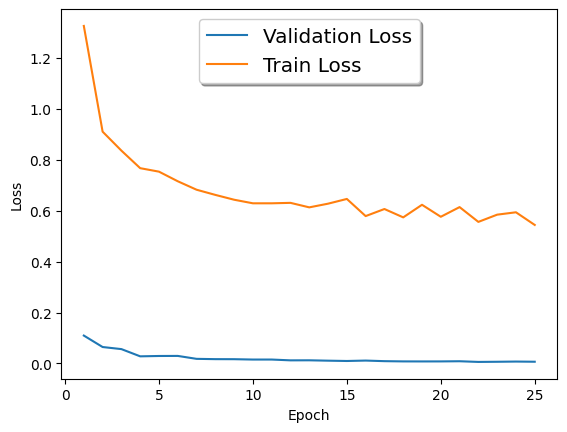

In [18]:
# Define the range of epochs (1 to 25, inclusive)
epochs = range(1, 26)
# Plot the validation loss over each epoch
plt.plot(epochs, np.array(val_loss), label="Validation Loss")
# Plot the training loss over each epoch
plt.plot(epochs, np.array(train_loss), label="Train Loss")
# Create a legend to differentiate between the training and validation loss plots
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Access the legend frame (optional, could be used for custom styling if needed)
legend.get_frame()
# Label the x-axis as "Epoch" to indicate the training progression
plt.xlabel("Epoch")
# Label the y-axis as "Loss" to indicate the loss values
plt.ylabel("Loss")
# Display the plot with the losses for training and validation over all epochs
plt.show()

This code plots some of the outputs of the test set:

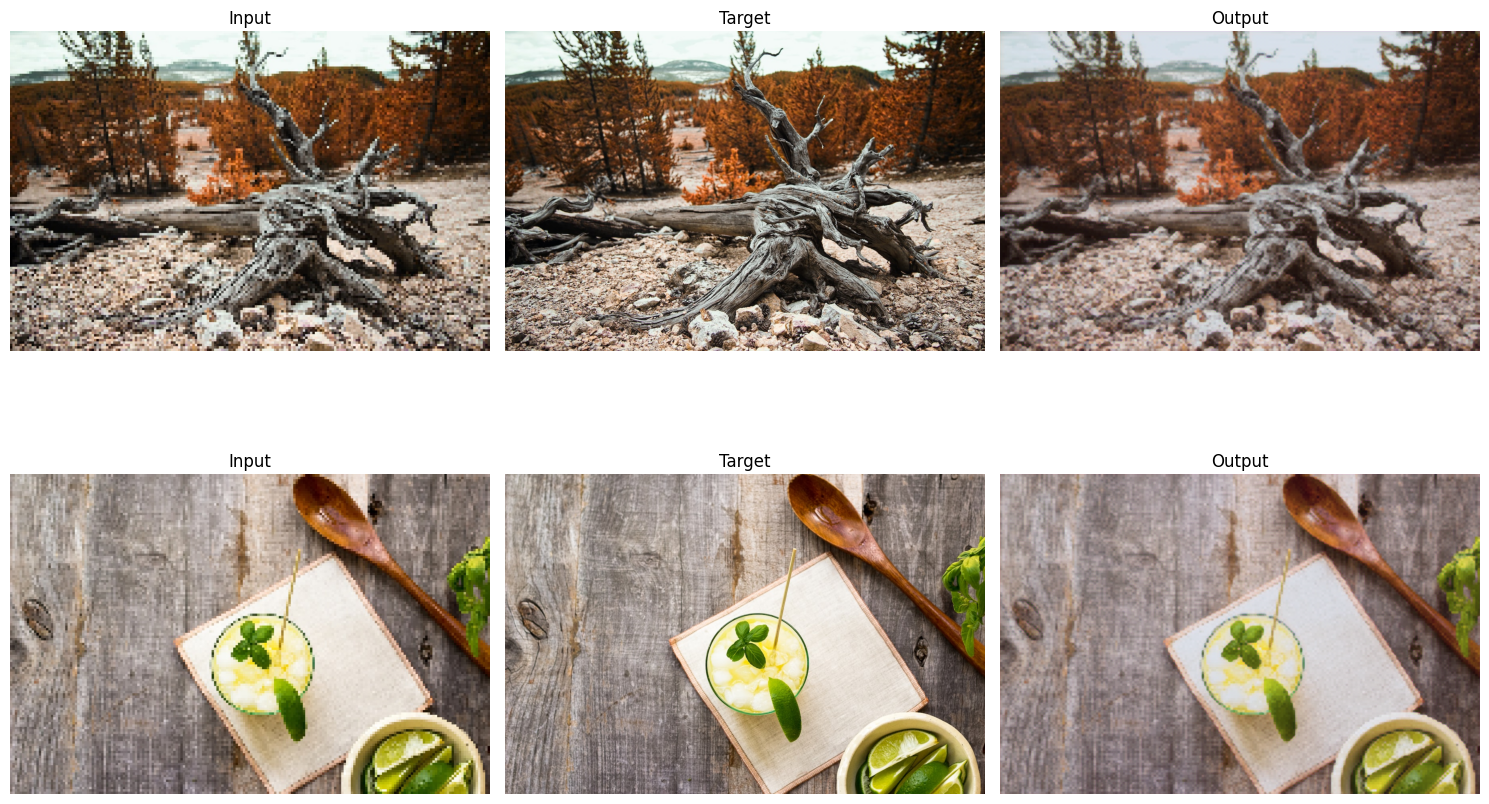

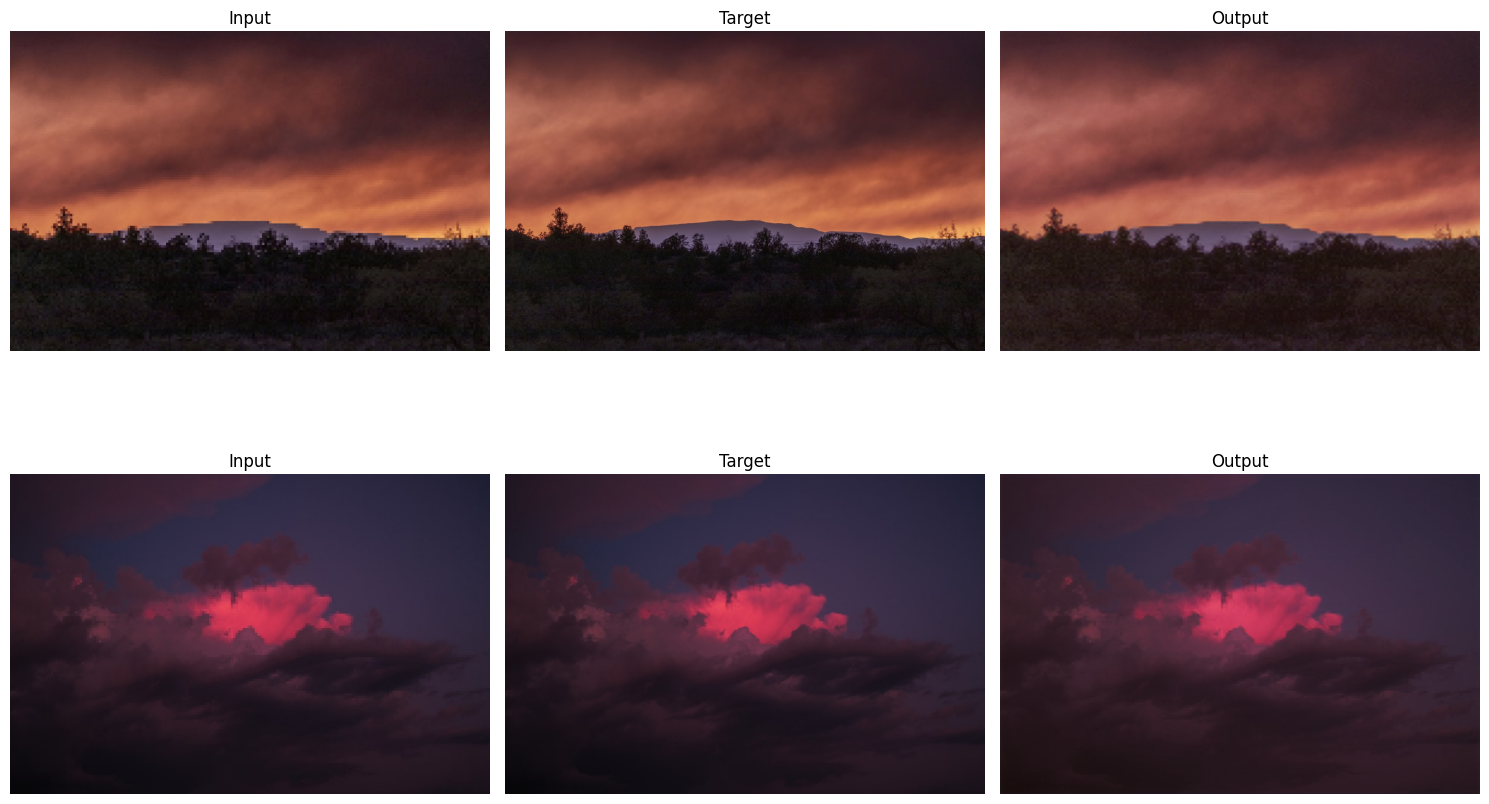

In [20]:
# Set the number of images to display per row in the subplot
num_images_to_display = 2  

# Iterate over the test data in batches
for i in range(280 // batch_size):
    with torch.no_grad():  # Disable gradient calculations for evaluation
        # Create a temporary dataset for the test images, using the current batch
        test_set_temp = ImageDataset(
            data[3492 + i * batch_size:3492 + (i + 1) * batch_size],
            transform=data_transform, shuffle=True  # Shuffle to randomize the test set
        )
        
        # Ensure there are images in the dataset
        if len(test_set_temp) != 0:
            # Load the temporary test dataset into a DataLoader
            test_dataloader_temp = DataLoader(
                test_set_temp, batch_size=batch_size, shuffle=True, num_workers=2
            )

            # Get a batch of inputs (low-res images) and targets (high-res images)
            inputs, targets = next(iter(test_dataloader_temp))
            inputs = inputs.to(device)  # Move input images to the GPU (or CPU)
            targets = targets.to(device)  # Move target images to the GPU (or CPU)

            # Perform the forward pass through the model to generate high-res outputs
            outputs = model(inputs)

            # For every 100 batches, display some random images for visual inspection
            if i % 100 == 0:
                # Randomly select indices of the images to display
                random_indices = random.sample(range(len(inputs)), num_images_to_display)

                # Create a figure with subplots to display the input, target, and output images
                fig, axes = plt.subplots(num_images_to_display, 3, figsize=(15, num_images_to_display * 5))

                # Iterate over the selected random images and plot them
                for row_idx, idx in enumerate(random_indices):
                    # Display the input low-res image in the first column
                    axes[row_idx, 0].imshow(inputs[idx].cpu().permute(1, 2, 0).numpy())  # Convert from tensor to image
                    axes[row_idx, 0].set_title("Input")  # Set title as 'Input' for low-res image
                    axes[row_idx, 0].axis('off')  # Hide axis for clean visualization

                    # Display the target high-res image in the second column
                    axes[row_idx, 1].imshow(targets[idx].cpu().permute(1, 2, 0).numpy())  # Convert from tensor to image
                    axes[row_idx, 1].set_title("Target")  # Set title as 'Target' for ground truth high-res image
                    axes[row_idx, 1].axis('off')  # Hide axis for clean visualization

                    # Display the model's output high-res image in the third column
                    axes[row_idx, 2].imshow(outputs[idx].cpu().permute(1, 2, 0).detach().numpy())  # Detach for plotting
                    axes[row_idx, 2].set_title("Output")  # Set title as 'Output' for model-generated high-res image
                    axes[row_idx, 2].axis('off')  # Hide axis for clean visualization

                # Adjust layout to prevent overlapping of subplots
                plt.tight_layout()
                
                # Display the entire figure containing the plotted images
                plt.show()

We can see the improvement in the quality of the images, which given that the epoch numbers were relevantly low, is a promising result.